In [140]:
run crazy.py

In [141]:
from sklearn.preprocessing import LabelEncoder
le_yn_y= LabelEncoder().fit(['N','Y'])
le_yn_n= LabelEncoder().fit(['Y','N'])
le_ab= LabelEncoder().fit(['A','B','C'])
his= pd.merge( his, mer.loc[:,['merchant_id','category_4','most_recent_sales_range','numerical_1']], on='merchant_id',how='left')
new= pd.merge( new, mer.loc[:,['merchant_id','category_4','most_recent_sales_range','numerical_1']], on='merchant_id',how='left')
his.authorized_flag= le_yn_y.transform( his.authorized_flag)
new.authorized_flag= le_yn_y.transform( new.authorized_flag)
his.category_4= his.category_4.fillna( method='ffill')
new.category_4= new.category_4.fillna( method='ffill')
his.category_4= le_yn_n.transform( his.category_4)
new.category_4= le_yn_n.transform( new.category_4)
his.category_3= his.category_3.fillna( method='ffill')
new.category_3= new.category_3.fillna( method='ffill')
his.category_3= le_ab.transform( his.category_3)
new.category_3= le_ab.transform( new.category_3)
his['due']= his.installments - his.category_3
new['due']= new.installments - new.category_3
his.purchase_date= his.purchase_date.dt.date
new.purchase_date= new.purchase_date.dt.date

In [142]:
subsector_trans_daily_max= his.groupby(['card_id','subsector_id','purchase_date']).size().reset_index().groupby('subsector_id')[0].nlargest().reset_index().groupby('subsector_id')[0].mean().reset_index()
his_subsector_trans_merchant_cnt= his.groupby(['card_id','subsector_id','merchant_id']).size().reset_index()
new_subsector_trans_merchant_cnt= new.groupby(['card_id','subsector_id','merchant_id']).size().reset_index()
his_subsector_trans_merchant_cnt.columns= ['card_id','subsector_id','merchant_id','subsector_merchant_cnt']
new_subsector_trans_merchant_cnt.columns= ['card_id','subsector_id','merchant_id','subsector_merchant_cnt']
merchant_time_dist= his.groupby(['card_id','merchant_id']).purchase_date.nunique().reset_index()
his_subsector_trans_merchant_uniq= his.groupby(['card_id','subsector_id']).merchant_id.nunique().reset_index()
new_subsector_trans_merchant_uniq= new.groupby(['card_id','subsector_id']).merchant_id.nunique().reset_index()
his_subsector_trans_merchant_uniq.columns= ['card_id','subsector_id','subsector_merchant_nuniq']
new_subsector_trans_merchant_uniq.columns= ['card_id','subsector_id','subsector_merchant_nuniq']
his['purchase_1']=his.purchase_amount/his.numerical_1
new['purchase_1']=new.purchase_amount/new.numerical_1

his= pd.merge( his, subsector_trans_daily_max, on='subsector_id',how='left')
new= pd.merge( new, subsector_trans_daily_max, on='subsector_id',how='left')
his['x_factor']=his.purchase_1/his[0]
new['x_factor']=new.purchase_1/new[0]
his['purchase_2']=his.purchase_amount*his.numerical_1
new['purchase_2']= new.purchase_amount*new.numerical_1

In [143]:
new_recent_purchase2_mean= new.pivot_table('purchase_2',columns='most_recent_sales_range',index='card_id',aggfunc=np.mean).reset_index()
his_recent_purchase2_mean= his.pivot_table('purchase_2',columns='most_recent_sales_range',index='card_id',aggfunc=np.mean).reset_index()
new_recent_purchase2_sum= new.pivot_table('purchase_2',columns='most_recent_sales_range',index='card_id',aggfunc=np.sum).reset_index()
his_recent_purchase2_sum= his.pivot_table('purchase_2',columns='most_recent_sales_range',index='card_id',aggfunc=np.sum).reset_index()

new_recent_xfactor_mean= new.pivot_table('x_factor',columns='most_recent_sales_range',index='card_id',aggfunc=np.mean).reset_index()
his_recent_xfactor_mean= his.pivot_table('x_factor',columns='most_recent_sales_range',index='card_id',aggfunc=np.mean).reset_index()
new_recent_xfactor_sum= new.pivot_table('x_factor',columns='most_recent_sales_range',index='card_id',aggfunc=np.sum).reset_index()
his_recent_xfactor_sum= his.pivot_table('x_factor',columns='most_recent_sales_range',index='card_id',aggfunc=np.sum).reset_index()

In [144]:
temp= his.groupby(['card_id','authorized_flag']).size().reset_index()
card_auth= temp.pivot_table( 0,columns='authorized_flag',index='card_id',aggfunc=np.sum).reset_index().fillna(0)
card_auth['non_auth_rate']= card_auth[0]/(card_auth[0]+card_auth[1])

his_merchant_trans_dist= his.groupby(['card_id','subsector_id','merchant_id','purchase_date']).size().reset_index().groupby(['card_id','merchant_id']).size().reset_index()
his_merchant_trans_dist= pd.merge(his_merchant_trans_dist, mer.loc[:,['merchant_id','subsector_id']],on='merchant_id',how='left')
his_merchant_fickleness= pd.merge( his_merchant_trans_dist.groupby(['card_id','subsector_id'])[0].sum().reset_index(),his_subsector_trans_merchant_uniq, on=['card_id','subsector_id'], how='left')
his_merchant_fickleness['fickleness']= his_merchant_fickleness.subsector_merchant_nuniq / his_merchant_fickleness[0]
his_merchant_fickleness= his_merchant_fickleness.groupby(['card_id']).fickleness.mean().reset_index()

new_merchant_trans_dist= new.groupby(['card_id','subsector_id','merchant_id','purchase_date']).size().reset_index().groupby(['card_id','merchant_id']).size().reset_index()
new_merchant_trans_dist= pd.merge(new_merchant_trans_dist, mer.loc[:,['merchant_id','subsector_id']],on='merchant_id',how='left')
new_merchant_fickleness= pd.merge( new_merchant_trans_dist.groupby(['card_id','subsector_id'])[0].sum().reset_index(),his_subsector_trans_merchant_uniq, on=['card_id','subsector_id'], how='left')
new_merchant_fickleness['fickleness']=new_merchant_fickleness.subsector_merchant_nuniq/new_merchant_fickleness[0]
new_merchant_fickleness= new_merchant_fickleness.groupby(['card_id']).fickleness.mean().reset_index()

In [145]:
agg_func= {
    'purchase_amount': ['sum', 'mean', 'max'],
    'x_factor': ['sum', 'mean', 'max'],
    'purchase_1': ['sum', 'mean', 'max'],
    'purchase_2': ['sum', 'mean', 'max'],
    'category_4': ['sum'],
    'due': ['sum','mean','max'],
}
his_final= his.groupby(['card_id']).agg(agg_func)
his_final.columns= [ '_'.join(col).strip() for col in his_final.columns.values]
his_final.reset_index( inplace= True)
his_final= pd.merge( his_final, his_merchant_fickleness, on='card_id',how='left')
his_final= pd.merge( his_final, card_auth, on='card_id',how='left')
his_final= pd.merge( his_final, his_recent_xfactor_mean, on='card_id',how='left')
his_final= pd.merge( his_final, his_recent_purchase2_mean, on='card_id',how='left')

new_final= new.groupby(['card_id']).agg(agg_func)
new_final.columns= [ '_'.join(col).strip() for col in new_final.columns.values]
new_final.reset_index( inplace= True)
new_final= pd.merge( new_final, new_merchant_fickleness, on='card_id',how='left')
new_final= pd.merge( new_final, new_recent_xfactor_mean, on='card_id',how='left')
new_final= pd.merge( new_final, new_recent_purchase2_mean, on='card_id',how='left')

In [146]:
his_final.columns= [ 'his_'+str(col) if col != 'card_id' else col for col in his_final.columns.values]
new_final.columns= [ 'new_'+str(col) if col != 'card_id' else col for col in new_final.columns.values]
train2= train.merge( new_final, on='card_id',how='left')
train2= train2.merge( his_final, on='card_id',how='left')
test2= test.merge( new_final, on='card_id',how='left')
test2= test2.merge( his_final, on='card_id',how='left')

In [53]:
target= train2.target
train3=train2.drop(['card_id','target','first_active_month'], axis= 1)
test3= test2.drop(['card_id','first_active_month'],axis=1)
import lightgbm as lgb
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train3))
predictions = np.zeros(len(test3))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train3.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train3.iloc[trn_idx],
                           label=target.iloc[trn_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )
    val_data = lgb.Dataset(train3.iloc[val_idx],
                           label=target.iloc[val_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(train3.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train3.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test3, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.79895	valid_1's rmse: 3.85822
[200]	training's rmse: 3.77078	valid_1's rmse: 3.84667
[300]	training's rmse: 3.74997	valid_1's rmse: 3.84093
[400]	training's rmse: 3.73354	valid_1's rmse: 3.83819
[500]	training's rmse: 3.71997	valid_1's rmse: 3.83665
[600]	training's rmse: 3.70841	valid_1's rmse: 3.8358
[700]	training's rmse: 3.6989	valid_1's rmse: 3.83524
[800]	training's rmse: 3.69015	valid_1's rmse: 3.83512
[900]	training's rmse: 3.68205	valid_1's rmse: 3.83516
[1000]	training's rmse: 3.67447	valid_1's rmse: 3.8351
[1100]	training's rmse: 3.66724	valid_1's rmse: 3.8351
Early stopping, best iteration is:
[1091]	training's rmse: 3.66795	valid_1's rmse: 3.83505
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.81835	valid_1's rmse: 3.77897
[200]	training's rmse: 3.78972	valid_1's rmse: 3.76703
[300]	training's rmse: 3.76878	valid_1's rmse: 3.76123
[400]	

In [147]:
new_trans_days_cnt= new.groupby(['card_id','purchase_date']).size().groupby('card_id').size().reset_index()
his_trans_days_cnt= his.groupby(['card_id','purchase_date']).size().groupby('card_id').size().reset_index()
new_trans_days_cnt.columns= ['card_id','new_trans_days']
his_trans_days_cnt.columns= ['card_id','his_trans_days']

In [101]:
new_trans_days_cnt[:5]

,card_id,new_trans_days
0,C_ID_00007093c1,2
1,C_ID_0001238066,19
2,C_ID_0001506ef0,2
3,C_ID_0001793786,14
4,C_ID_000183fdda,10


In [148]:
new_cat3_count= pd.crosstab( new.card_id,new.category_3).reset_index()
his_cat3_count= pd.crosstab( his.card_id,his.category_3).reset_index()
new_cat3_count.columns= ['card_id','new_0','new_1','new_1']
his_cat3_count.columns= ['card_id','his_0','his_1','his_1']

In [149]:
#trans months signifies period of engagement i.e first purchase minus last
his_first_month= his.groupby('card_id').month_lag.min().reset_index()
his_last_month= his.groupby('card_id').month_lag.max().reset_index()
his_first_month.columns= ['card_id','first_month_lag']
his_last_month.columns= ['card_id','last_month_lag']
trans_months= pd.merge( his_first_month, his_last_month, on='card_id',how='inner')
trans_months['engagement_months']= trans_months.last_month_lag - trans_months.first_month_lag

In [150]:
train2= pd.merge( train2, trans_months[['card_id','engagement_months']], how='left',on='card_id')
train2= pd.merge( train2, new_cat3_count, how='left',on='card_id')
train2= pd.merge( train2, his_cat3_count, how='left',on='card_id')
train2= pd.merge( train2, his_trans_days_cnt, how='left',on='card_id')
train2= pd.merge( train2, new_trans_days_cnt, how='left',on='card_id')

test2= pd.merge( test2, trans_months[['card_id','engagement_months']], how='left',on='card_id')
test2= pd.merge( test2, new_cat3_count, how='left',on='card_id')
test2= pd.merge( test2, his_cat3_count, how='left',on='card_id')
test2= pd.merge( test2, his_trans_days_cnt, how='left',on='card_id')
test2= pd.merge( test2, new_trans_days_cnt, how='left',on='card_id')

import datetime
train2['elapsed_time']= ( datetime.date( 2018,2,1) - 
                          train.first_active_month.dt.date).dt.days
test2['elapsed_time']= ( datetime.date( 2018,2,1) - 
                          test.first_active_month.dt.date).dt.days

In [107]:
target= train2.target
train3=train2.drop(['card_id','target','first_active_month'], axis= 1)
test3= test2.drop(['card_id','first_active_month'],axis=1)
import lightgbm as lgb
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train3))
predictions = np.zeros(len(test3))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train3.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train3.iloc[trn_idx],
                           label=target.iloc[trn_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )
    val_data = lgb.Dataset(train3.iloc[val_idx],
                           label=target.iloc[val_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(train3.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train3.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test3, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.77241	valid_1's rmse: 3.83227
[200]	training's rmse: 3.72766	valid_1's rmse: 3.80541
[300]	training's rmse: 3.69508	valid_1's rmse: 3.78907
[400]	training's rmse: 3.66764	valid_1's rmse: 3.77737
[500]	training's rmse: 3.64575	valid_1's rmse: 3.77068
[600]	training's rmse: 3.62738	valid_1's rmse: 3.7658
[700]	training's rmse: 3.61161	valid_1's rmse: 3.76208
[800]	training's rmse: 3.59946	valid_1's rmse: 3.76062
[900]	training's rmse: 3.58819	valid_1's rmse: 3.75939
[1000]	training's rmse: 3.57784	valid_1's rmse: 3.75823
[1100]	training's rmse: 3.56832	valid_1's rmse: 3.75752
[1200]	training's rmse: 3.5602	valid_1's rmse: 3.75728
[1300]	training's rmse: 3.55194	valid_1's rmse: 3.75681
[1400]	training's rmse: 3.54376	valid_1's rmse: 3.75649
[1500]	training's rmse: 3.53596	valid_1's rmse: 3.75639
Early stopping, best iteration is:
[1460]	training's rmse: 3.53909	valid_1's rmse: 3.7563
fold n°1
Training 

In [12]:
#observe card_id with 999 installment, then trim due or not?
#aggregate count of cat_1

In [151]:
del trans_months, his_last_month, his_first_month, his_cat3_count, new_cat3_count,\
    his_trans_days_cnt, new_trans_days_cnt, new_merchant_fickleness, his_merchant_fickleness,\
    new_merchant_trans_dist, his_merchant_trans_dist, card_auth, temp, \
    new_recent_purchase2_mean, new_recent_purchase2_sum, new_recent_xfactor_mean, new_recent_xfactor_sum,\
    his_recent_purchase2_mean, his_recent_purchase2_sum, his_recent_xfactor_mean, his_recent_xfactor_sum,\
    merchant_time_dist, subsector_trans_daily_max,\
    his_subsector_trans_merchant_cnt, his_subsector_trans_merchant_uniq,\
    new_subsector_trans_merchant_cnt, new_subsector_trans_merchant_uniq
import gc
gc.collect()

25292

In [152]:
his_temp= his[['card_id','category_3','installments','category_1','category_4']]
his_temp['999_cnt']= his_temp.installments.transform( lambda x: 1 if x==999 else 0)
his_temp['modified_installments']= his_temp.installments
his_temp.loc[ his_temp.installments==999,'modified_installments']= his_temp.loc[ his_temp.installments==999, 'category_3']
his_temp['modified_due']= his_temp.modified_installments - his_temp.category_3

new_temp= new[['card_id','category_3','installments','category_1','category_4']]
new_temp['999_cnt']= new_temp.installments.transform( lambda x: 1 if x==999 else 0)
new_temp['modified_installments']= new_temp.installments
new_temp.loc[ new_temp.installments==999, 'modified_installments']= new_temp.loc[ new_temp.installments==999,'category_3']
new_temp['modified_due']= new_temp.modified_installments - new_temp.category_3

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [153]:
agg_func= { 
    '999_cnt':['sum','mean'],
    'modified_due':['sum','mean'],
    'modified_installments':['sum','mean'],
    'category_4':'mean',
    'category_1':['sum','mean']
            }
his_temp.category_1= le_yn_n.transform( his_temp.category_1)
new_temp.category_1= le_yn_n.transform( new_temp.category_1)

his_temp= his_temp.groupby('card_id').agg( agg_func)
his_temp.columns= [ '_'.join(col).strip() for col in his_temp.columns.values]
his_temp.reset_index( inplace= True)

new_temp= new_temp.groupby('card_id').agg( agg_func)
new_temp.columns= [ '_'.join(col).strip() for col in new_temp.columns.values]
new_temp.reset_index( inplace= True)

his_temp.columns= [ 'his_'+str(col) if col != 'card_id' else col for col in his_temp.columns.values]
new_temp.columns= [ 'new_'+str(col) if col != 'card_id' else col for col in new_temp.columns.values]
train2= train2.merge( new_temp, on='card_id',how='left')
train2= train2.merge( his_temp, on='card_id',how='left')
test2= test2.merge( new_temp, on='card_id',how='left')
test2= test2.merge( his_temp, on='card_id',how='left')

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [154]:
target= train2.target
train3=train2.drop(['card_id','target','first_active_month'], axis= 1)
test3= test2.drop(['card_id','first_active_month'],axis=1)
import lightgbm as lgb
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train3))
predictions = np.zeros(len(test3))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train3.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train3.iloc[trn_idx],
                           label=target.iloc[trn_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )
    val_data = lgb.Dataset(train3.iloc[val_idx],
                           label=target.iloc[val_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(train3.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train3.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test3, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.76835	valid_1's rmse: 3.82842
[200]	training's rmse: 3.71836	valid_1's rmse: 3.79622
[300]	training's rmse: 3.68413	valid_1's rmse: 3.7791
[400]	training's rmse: 3.65716	valid_1's rmse: 3.7682
[500]	training's rmse: 3.63359	valid_1's rmse: 3.76012
[600]	training's rmse: 3.61548	valid_1's rmse: 3.75516
[700]	training's rmse: 3.60108	valid_1's rmse: 3.7523
[800]	training's rmse: 3.58903	valid_1's rmse: 3.75052
[900]	training's rmse: 3.5785	valid_1's rmse: 3.74915
[1000]	training's rmse: 3.56848	valid_1's rmse: 3.74781
[1100]	training's rmse: 3.55991	valid_1's rmse: 3.74711
[1200]	training's rmse: 3.55146	valid_1's rmse: 3.74652
[1300]	training's rmse: 3.54298	valid_1's rmse: 3.74591
[1400]	training's rmse: 3.53567	valid_1's rmse: 3.74562
[1500]	training's rmse: 3.528	valid_1's rmse: 3.74554
[1600]	training's rmse: 3.52049	valid_1's rmse: 3.74535
[1700]	training's rmse: 3.51297	valid_1's rmse: 3.74519


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78758	valid_1's rmse: 3.75196
[200]	training's rmse: 3.73676	valid_1's rmse: 3.72128
[300]	training's rmse: 3.70188	valid_1's rmse: 3.70507
[400]	training's rmse: 3.6743	valid_1's rmse: 3.69549
[500]	training's rmse: 3.64946	valid_1's rmse: 3.68834
[600]	training's rmse: 3.63079	valid_1's rmse: 3.68448
[700]	training's rmse: 3.61487	valid_1's rmse: 3.68206
[800]	training's rmse: 3.60175	valid_1's rmse: 3.68057
[900]	training's rmse: 3.59129	valid_1's rmse: 3.6798
[1000]	training's rmse: 3.58166	valid_1's rmse: 3.67929
[1100]	training's rmse: 3.57205	valid_1's rmse: 3.67854
[1200]	training's rmse: 3.56349	valid_1's rmse: 3.67817
[1300]	training's rmse: 3.55537	valid_1's rmse: 3.67802
[1400]	training's rmse: 3.5483	valid_1's rmse: 3.67806
Early stopping, best iteration is:
[1327]	training's rmse: 3.55349	valid_1's rmse: 3.67795
fold n°2


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.79262	valid_1's rmse: 3.72832
[200]	training's rmse: 3.74134	valid_1's rmse: 3.69908
[300]	training's rmse: 3.70599	valid_1's rmse: 3.68358
[400]	training's rmse: 3.67863	valid_1's rmse: 3.67378
[500]	training's rmse: 3.6544	valid_1's rmse: 3.66598
[600]	training's rmse: 3.63524	valid_1's rmse: 3.66083
[700]	training's rmse: 3.61961	valid_1's rmse: 3.65789
[800]	training's rmse: 3.60805	valid_1's rmse: 3.65641


KeyboardInterrupt: 

In [90]:
#groupby authorized flags and hope for the bestest
#In auth_group/non_auth_group ....city_id(nunique), 
    #installments(sum,mean, min, max, std), purchase_amount(sum,max, mean,std)
#multiply elapsed with feat_1_2_3
#trans_month_cnt(month_lag_unique), cat_3(std,nunique), month_lag(min)
#merchant_id(nunique), subsector_id(nunique), most_recent(nunique, std)

In [155]:
agg_func={
    'city_id':'nunique',
    'installments':['sum','mean','max','min','std'],
    'purchase_amount': ['sum','mean','max','min','std'],
}

auth= his.loc[ his.authorized_flag==1,['card_id','city_id','installments','purchase_amount']]
non_auth= his.loc[ his.authorized_flag==0,['card_id','city_id','installments','purchase_amount']]

auth= auth.groupby('card_id').agg( agg_func)
auth.columns= [ '_'.join(col).strip() for col in auth.columns.values]
auth.reset_index( inplace= True)
non_auth= non_auth.groupby('card_id').agg( agg_func)
non_auth.columns= [ '_'.join(col).strip() for col in non_auth.columns.values]
non_auth.reset_index( inplace= True)

auth.columns= [ 'auth_'+str(col) if col != 'card_id' else col for col in auth.columns.values]
non_auth.columns= [ 'non_auth_'+str(col) if col != 'card_id' else col for col in non_auth.columns.values]

In [156]:
#trans_month_cnt(month_lag_unique), cat_3(std,nunique), month_lag(min)
his_trans_month_cnt= his.groupby('card_id').month_lag.nunique().reset_index()
new_trans_month_cnt= new.groupby('card_id').month_lag.nunique().reset_index()
his_trans_month_cnt.columns= ['card_id','his_months_unique']
new_trans_month_cnt.columns= ['card_id','new_months_unique']

In [157]:
his_trans_month_min= his.groupby('card_id').month_lag.min().reset_index()
his_trans_month_min.columns= ['card_id','his_months_min']
his_cat3_cnt= his.groupby('card_id').category_3.nunique().reset_index()
new_cat3_cnt= new.groupby('card_id').category_3.nunique().reset_index()
his_cat3_cnt.columns= ['card_id','his_cat3_unique']
new_cat3_cnt.columns= ['card_id','new_cat3_unique']
his_cat3_std= his.groupby('card_id').category_3.std().reset_index()
new_cat3_std= new.groupby('card_id').category_3.std().reset_index()
his_cat3_std.columns= ['card_id','his_cat3_std']
new_cat3_std.columns= ['card_id','new_cat3_std']

In [158]:
#merchant_id(nunique), subsector_id(nunique), most_recent(nunique, std)
his_trans_mer_cnt= his.groupby('card_id').merchant_id.nunique().reset_index()
new_trans_mer_cnt= new.groupby('card_id').merchant_id.nunique().reset_index()
his_trans_mer_cnt.columns= ['card_id','his_mer_unique']
new_trans_mer_cnt.columns= ['card_id','new_mer_unique']

his_subsector_cnt= his.groupby('card_id').subsector_id.nunique().reset_index()
new_subsector_cnt= new.groupby('card_id').subsector_id.nunique().reset_index()
his_subsector_cnt.columns= ['card_id','new_subsector_cnt']
new_subsector_cnt.columns= ['card_id','new_subsector_cnt']

his_most_recent_cnt= his.groupby('card_id').most_recent_sales_range.nunique().reset_index()
new_most_recent_cnt= new.groupby('card_id').most_recent_sales_range.nunique().reset_index()
his_most_recent_cnt.columns= ['card_id','new_subsector_cnt']
new_most_recent_cnt.columns= ['card_id','new_subsector_cnt']

In [159]:
train2= train2.merge( auth, on='card_id',how='left')
train2= train2.merge( non_auth, on='card_id',how='left')
train2= train2.merge( his_trans_month_cnt, on='card_id',how='left')
train2= train2.merge( new_trans_month_cnt, on='card_id',how='left')
train2= train2.merge( his_trans_month_min, on='card_id',how='left')
train2= train2.merge( his_cat3_cnt, on='card_id',how='left')
train2= train2.merge( his_cat3_std, on='card_id',how='left')
train2= train2.merge( new_cat3_cnt, on='card_id',how='left')
train2= train2.merge( new_cat3_std, on='card_id',how='left')
train2= train2.merge( his_trans_mer_cnt, on='card_id',how='left')
train2= train2.merge( new_trans_mer_cnt, on='card_id',how='left')
train2= train2.merge( his_subsector_cnt, on='card_id',how='left')
train2= train2.merge( new_subsector_cnt, on='card_id',how='left')
train2= train2.merge( his_most_recent_cnt, on='card_id',how='left')
train2= train2.merge( new_most_recent_cnt, on='card_id',how='left')

test2= test2.merge( auth, on='card_id',how='left')
test2= test2.merge( non_auth, on='card_id',how='left')
test2= test2.merge( his_trans_month_cnt, on='card_id',how='left')
test2= test2.merge( new_trans_month_cnt, on='card_id',how='left')
test2= test2.merge( his_trans_month_min, on='card_id',how='left')
test2= test2.merge( his_cat3_cnt, on='card_id',how='left')
test2= test2.merge( his_cat3_std, on='card_id',how='left')
test2= test2.merge( new_cat3_cnt, on='card_id',how='left')
test2= test2.merge( new_cat3_std, on='card_id',how='left')
test2= test2.merge( his_trans_mer_cnt, on='card_id',how='left')
test2= test2.merge( new_trans_mer_cnt, on='card_id',how='left')
test2= test2.merge( his_subsector_cnt, on='card_id',how='left')
test2= test2.merge( new_subsector_cnt, on='card_id',how='left')
test2= test2.merge( his_most_recent_cnt, on='card_id',how='left')
test2= test2.merge( new_most_recent_cnt, on='card_id',how='left')

In [160]:
target= train2.target
train3=train2.drop(['card_id','target','first_active_month'], axis= 1)
test3= test2.drop(['card_id','first_active_month'],axis=1)
import lightgbm as lgb
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train3))
predictions = np.zeros(len(test3))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train3.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train3.iloc[trn_idx],
                           label=target.iloc[trn_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )
    val_data = lgb.Dataset(train3.iloc[val_idx],
                           label=target.iloc[val_idx],
                           categorical_feature=['feature_1','feature_2','feature_3']
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 100)
    
    oof[val_idx] = clf.predict(train3.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train3.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test3, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.75765	valid_1's rmse: 3.81873
[200]	training's rmse: 3.70459	valid_1's rmse: 3.78453
[300]	training's rmse: 3.66504	valid_1's rmse: 3.76375
[400]	training's rmse: 3.63519	valid_1's rmse: 3.75097
[500]	training's rmse: 3.61116	valid_1's rmse: 3.74233
[600]	training's rmse: 3.59199	valid_1's rmse: 3.73705
[700]	training's rmse: 3.57701	valid_1's rmse: 3.73393
[800]	training's rmse: 3.56379	valid_1's rmse: 3.7319
[900]	training's rmse: 3.5514	valid_1's rmse: 3.73017
[1000]	training's rmse: 3.54058	valid_1's rmse: 3.72919
[1100]	training's rmse: 3.53085	valid_1's rmse: 3.72836
[1200]	training's rmse: 3.52166	valid_1's rmse: 3.72768
[1300]	training's rmse: 3.51224	valid_1's rmse: 3.72716
[1400]	training's rmse: 3.50396	valid_1's rmse: 3.72664
[1500]	training's rmse: 3.49569	valid_1's rmse: 3.72643
[1600]	training's rmse: 3.48718	valid_1's rmse: 3.72591
[1700]	training's rmse: 3.47873	valid_1's rmse: 3.72

/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.7772	valid_1's rmse: 3.74283
[200]	training's rmse: 3.72261	valid_1's rmse: 3.71044
[300]	training's rmse: 3.68172	valid_1's rmse: 3.69179
[400]	training's rmse: 3.65019	valid_1's rmse: 3.68063
[500]	training's rmse: 3.62397	valid_1's rmse: 3.67322
[600]	training's rmse: 3.60427	valid_1's rmse: 3.66912
[700]	training's rmse: 3.58823	valid_1's rmse: 3.66647
[800]	training's rmse: 3.57438	valid_1's rmse: 3.66479
[900]	training's rmse: 3.56189	valid_1's rmse: 3.66361
[1000]	training's rmse: 3.55133	valid_1's rmse: 3.66277
[1100]	training's rmse: 3.5408	valid_1's rmse: 3.66193
[1200]	training's rmse: 3.5311	valid_1's rmse: 3.66148
[1300]	training's rmse: 3.52261	valid_1's rmse: 3.66107
[1400]	training's rmse: 3.51436	valid_1's rmse: 3.66102
[1500]	training's rmse: 3.50598	valid_1's rmse: 3.6608
[1600]	training's rmse: 3.49695	valid_1's rmse: 3.6606
[1700]	training's rmse: 3.4892	valid_1's rmse: 3.66037


/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78083	valid_1's rmse: 3.71954
[200]	training's rmse: 3.72665	valid_1's rmse: 3.6886
[300]	training's rmse: 3.68609	valid_1's rmse: 3.67002
[400]	training's rmse: 3.65471	valid_1's rmse: 3.65832
[500]	training's rmse: 3.62978	valid_1's rmse: 3.65064
[600]	training's rmse: 3.6106	valid_1's rmse: 3.64609
[700]	training's rmse: 3.59459	valid_1's rmse: 3.64304
[800]	training's rmse: 3.58108	valid_1's rmse: 3.64105
[900]	training's rmse: 3.56928	valid_1's rmse: 3.63971
[1000]	training's rmse: 3.55763	valid_1's rmse: 3.63879
[1100]	training's rmse: 3.54723	valid_1's rmse: 3.63778
[1200]	training's rmse: 3.53814	valid_1's rmse: 3.63719
[1300]	training's rmse: 3.5288	valid_1's rmse: 3.63677
[1400]	training's rmse: 3.51965	valid_1's rmse: 3.63634
[1500]	training's rmse: 3.51056	valid_1's rmse: 3.636
[1600]	training's rmse: 3.5021	valid_1's rmse: 3.63594
[1700]	training's rmse: 3.4935	valid_1's rmse: 3.63536
[

/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.73157	valid_1's rmse: 3.92342
[200]	training's rmse: 3.67897	valid_1's rmse: 3.89061
[300]	training's rmse: 3.63947	valid_1's rmse: 3.86963
[400]	training's rmse: 3.60821	valid_1's rmse: 3.85663
[500]	training's rmse: 3.58353	valid_1's rmse: 3.84811
[600]	training's rmse: 3.56377	valid_1's rmse: 3.84281
[700]	training's rmse: 3.5482	valid_1's rmse: 3.83992
[800]	training's rmse: 3.5341	valid_1's rmse: 3.83732
[900]	training's rmse: 3.52069	valid_1's rmse: 3.83529
[1000]	training's rmse: 3.5094	valid_1's rmse: 3.83384
[1100]	training's rmse: 3.49876	valid_1's rmse: 3.83287
[1200]	training's rmse: 3.48881	valid_1's rmse: 3.83193
[1300]	training's rmse: 3.48021	valid_1's rmse: 3.83172
[1400]	training's rmse: 3.47079	valid_1's rmse: 3.83122
[1500]	training's rmse: 3.46234	valid_1's rmse: 3.83102
[1600]	training's rmse: 3.45392	valid_1's rmse: 3.83089
[1700]	training's rmse: 3.44613	valid_1's rmse: 3.830

/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1194: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:753: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.77763	valid_1's rmse: 3.72972
[200]	training's rmse: 3.72317	valid_1's rmse: 3.69789
[300]	training's rmse: 3.68293	valid_1's rmse: 3.67923
[400]	training's rmse: 3.65232	valid_1's rmse: 3.668
[500]	training's rmse: 3.62725	valid_1's rmse: 3.6616
[600]	training's rmse: 3.60778	valid_1's rmse: 3.65782
[700]	training's rmse: 3.59029	valid_1's rmse: 3.65544
[800]	training's rmse: 3.57687	valid_1's rmse: 3.6543
[900]	training's rmse: 3.56345	valid_1's rmse: 3.65323
[1000]	training's rmse: 3.55315	valid_1's rmse: 3.65254
[1100]	training's rmse: 3.54225	valid_1's rmse: 3.65197
[1200]	training's rmse: 3.53316	valid_1's rmse: 3.65176
[1300]	training's rmse: 3.52423	valid_1's rmse: 3.65143
[1400]	training's rmse: 3.51584	valid_1's rmse: 3.65146
Early stopping, best iteration is:
[1363]	training's rmse: 3.51891	valid_1's rmse: 3.65138
CV score: 3.70101 


In [161]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission4.csv", index=False)

In [118]:
train2['elapsed_feat1']= train2.elapsed_time * train2.feature_1
train2['elapsed_feat2']= train2.elapsed_time * train2.feature_2
test2['elapsed_feat1']= test2.elapsed_time * test2.feature_1
test2['elapsed_feat']= test2.elapsed_time * test2.feature_2

In [164]:
#Above was tested i.e elapsed_feat...
#unsuccessful

In [121]:
train2.to_csv('mega_train.csv')
test2.to_csv('mega_test.csv')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


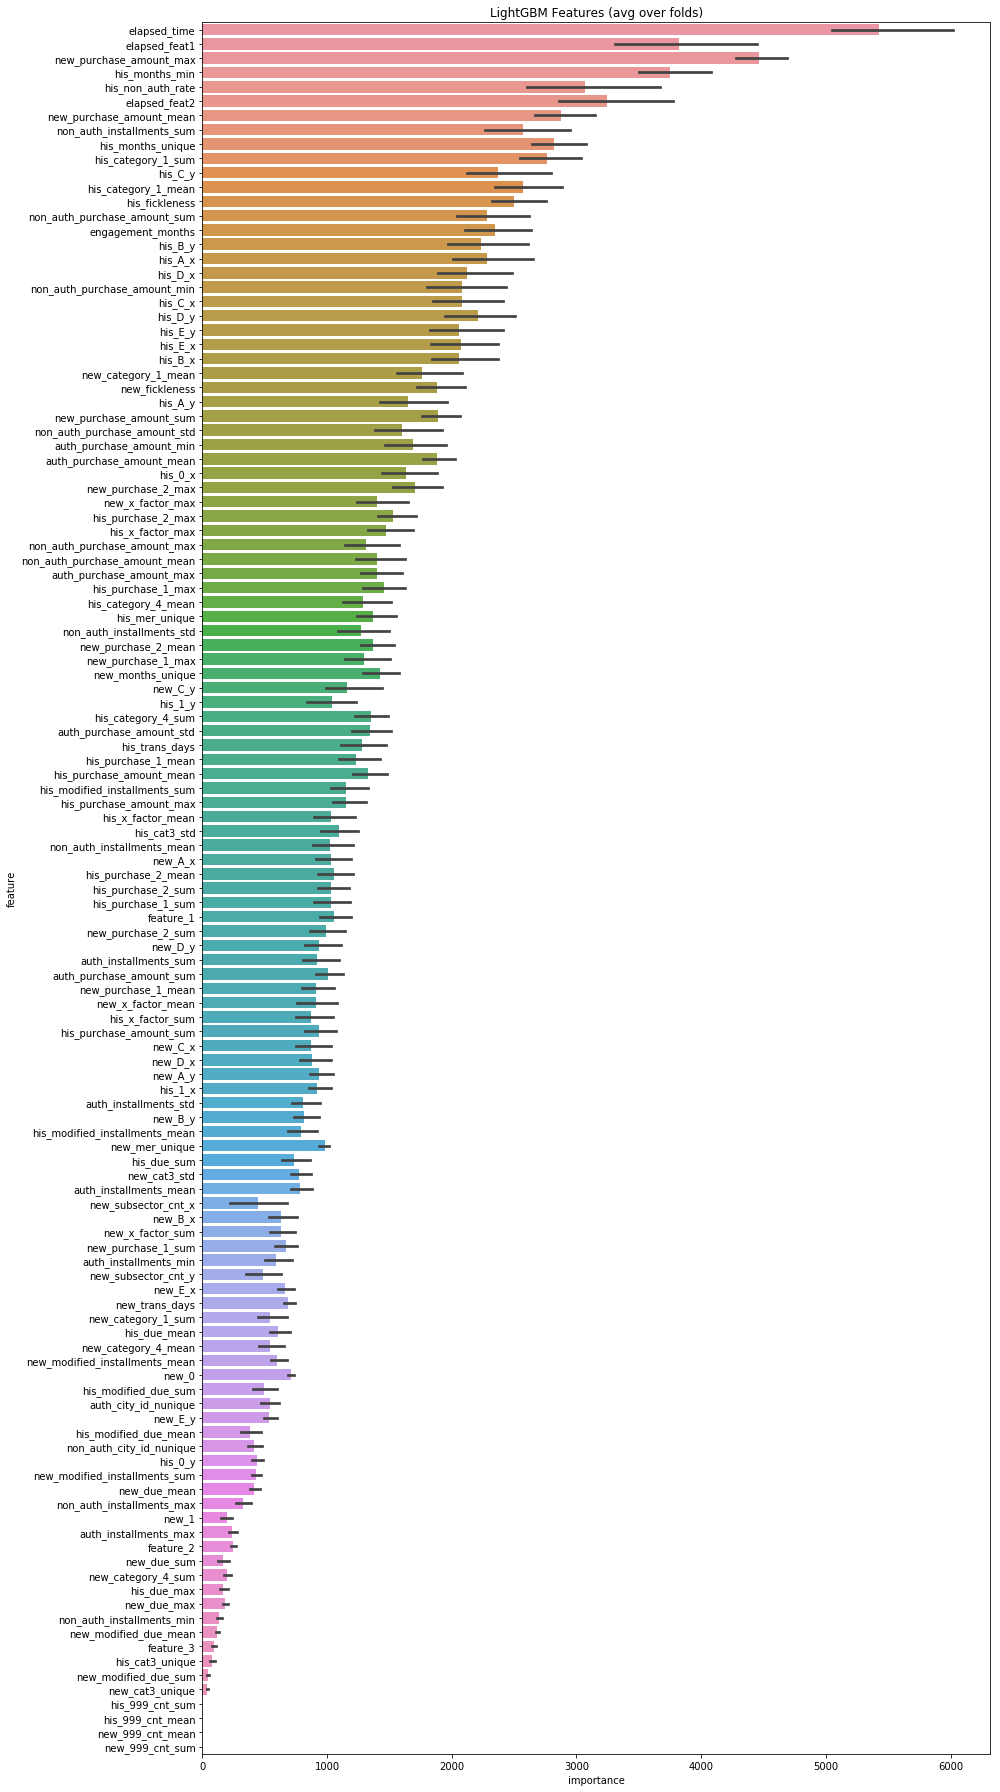

In [125]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
import seaborn as sns
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [129]:
cols[:30]

Index(['elapsed_time', 'new_purchase_amount_max', 'elapsed_feat1',
       'his_months_min', 'elapsed_feat2', 'his_non_auth_rate',
       'new_purchase_amount_mean', 'his_months_unique', 'his_category_1_sum',
       'his_category_1_mean', 'non_auth_installments_sum', 'his_fickleness',
       'his_C_y', 'engagement_months', 'non_auth_purchase_amount_sum',
       'his_A_x', 'his_B_y', 'his_D_y', 'his_D_x', 'his_C_x',
       'non_auth_purchase_amount_min', 'his_E_x', 'his_B_x', 'his_E_y',
       'new_purchase_amount_sum', 'new_fickleness',
       'auth_purchase_amount_mean', 'new_category_1_mean',
       'new_purchase_2_max', 'auth_purchase_amount_min'],
      dtype='object', name='feature')

In [131]:
his_final[:10]

,card_id,his_purchase_amount_sum,his_purchase_amount_mean,his_purchase_amount_max,his_x_factor_sum,his_x_factor_mean,his_x_factor_max,his_purchase_1_sum,his_purchase_1_mean,his_purchase_1_max,his_purchase_2_sum,his_purchase_2_mean,his_purchase_2_max,his_category_4_sum,his_due_sum,his_due_mean,his_due_max,his_fickleness,his_0,his_1,his_non_auth_rate,his_A_x,his_B_x,his_C_x,his_D_x,his_E_x,his_A_y,his_B_y,his_C_y,his_D_y,his_E_y
0,C_ID_00007093c1,-76.845041,-0.515739,1.507069,38.433706,0.257944,1.636089,1360.733731,9.132441,40.247777,-101.195314,-0.679163,2.080042,49,19,0.127517,4,0.496902,35.0,114.0,0.234899,0.198753,0.197125,0.040045,0.432518,-0.048327,-1.634720,-1.800689,0.136564,0.026320,0.024379
1,C_ID_0001238066,-72.447201,-0.589002,0.768095,33.937454,0.275914,1.520167,1160.055877,9.431349,56.550211,-813.937489,-6.617378,0.042234,20,43,0.349593,8,0.870089,3.0,120.0,0.024390,0.013032,0.367128,0.291225,0.362787,0.288736,-50.335848,-0.291362,-0.061873,0.033654,0.032014
2,C_ID_0001506ef0,-36.037843,-0.529968,1.493545,13.261862,0.195027,0.806114,535.273235,7.871665,41.471088,-40.881642,-0.601201,0.580541,67,0,0.000000,0,0.743867,4.0,64.0,0.058824,0.164957,0.114925,0.140318,0.396049,0.245504,-0.812250,-1.639751,-0.043961,0.039514,0.033041
3,C_ID_0001793786,-39.408680,-0.177517,4.554145,55.684904,0.250833,59.000947,2099.125933,9.455522,2194.835236,-49.817174,-0.224402,4.614893,157,0,0.000000,0,0.766393,27.0,195.0,0.121622,0.088174,1.143564,-0.115083,0.128572,0.335476,-0.005648,-0.465999,-0.381553,0.008718,0.016403
4,C_ID_000183fdda,-72.033025,-0.483443,2.764788,8.878428,0.059587,2.714455,265.408507,1.781265,100.977745,-8.289332,-0.055633,4.709785,142,83,0.557047,8,0.758573,7.0,142.0,0.046980,0.032998,0.151632,-0.022530,0.068705,0.004615,0.013807,-0.144103,-0.026963,-0.006826,0.017178
5,C_ID_00024e244b,-43.678073,-0.598330,2.258395,6.367654,0.087228,0.521940,415.433518,5.690870,22.323250,-17.181441,-0.235362,0.228477,38,0,0.000000,0,0.386621,17.0,56.0,0.232877,0.041410,-0.002201,-0.021611,0.179882,0.248138,0.010378,-1.949006,-0.275489,0.041042,0.039470
6,C_ID_0002709b5a,-47.659542,-0.652870,-0.336684,16.110349,0.220690,2.757233,790.914474,10.834445,89.474402,-8.514992,-0.116644,0.041198,21,43,0.589041,10,0.816621,6.0,67.0,0.082192,0.124377,0.235095,-0.173974,0.379772,0.772631,-0.099835,-0.051406,-0.409772,0.023250,0.029203
7,C_ID_00027503e2,-33.329209,-0.740649,-0.734135,-5.705004,-0.126778,1.050103,-134.352237,-2.985605,94.089231,0.408966,0.009088,0.042866,6,0,0.000000,0,0.661538,19.0,26.0,0.422222,0.159948,0.621126,0.117262,-1.115271,0.203772,0.042263,0.033446,-0.018825,0.033888,0.037955
8,C_ID_000298032a,-17.722253,-0.537038,2.577843,-0.172183,-0.005218,3.345440,213.013507,6.454955,86.981442,-131.785614,-3.993503,0.040356,14,0,0.000000,0,0.852778,3.0,30.0,0.090909,0.071906,0.274198,-2.370026,0.227414,0.653167,-14.420435,-0.392946,-0.027973,0.037556,0.031121
9,C_ID_0002ba3c2e,-45.048446,-0.634485,-0.097011,7.612692,0.107221,1.636089,492.658818,6.938857,40.247777,-20.357831,-0.286730,0.042666,11,0,0.000000,0,0.839626,15.0,56.0,0.211268,0.049437,-0.062418,0.158667,0.097333,0.228328,-1.896014,-0.652294,-0.006070,0.004009,0.033799


In [132]:
his_final.shape, new_final.shape

((325540, 31), (290001, 28))

In [ ]:

>>>
>>> from sklearn.neighbors import NearestNeighbors
>>> import numpy as np
>>> X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
>>> nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
>>> distances, indices = nbrs.kneighbors(X)
>>> indices

In [133]:
from sklearn.neighbors import NearestNeighbors

In [137]:
samples = [[0, 0, 2], [1, 0, 0], [0, 0, 1],[0.1,0,1.3]]
neigh = NearestNeighbors(2, 0.4)
neigh.fit(samples)  #doctest: +ELLIPSIS
neigh.kneighbors([[0, 0, 1.3]], 2, return_distance=False)

array([[3, 2]])

In [138]:
NearestNeighbors?

In [162]:
import sklearn
sklearn.__version__

'0.20.2'

In [ ]:
cols = [c for c in train if c.startswith('hist')]
train.loc[train['hist_transactions_count'].isnull(), cols] = 0
test.loc[test['hist_transactions_count'].isnull(), cols] = 0

cols = [c for c in train if c.startswith('new')]
train.loc[train['new_transactions_count'].isnull(), cols] = 0
test.loc[test['new_transactions_count'].isnull(), cols] = 0

cols = [c for c in train if c.endswith('std')]
for c in cols:
    train.loc[train[c].isnull(), c] = 0
    test.loc[test[c].isnull(), c] = 0

train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

hist_columns = [(c, c.replace('new', 'auth')) for c in train.columns if 'hist' in c]
for c in hist_columns:
        col_name = 'ratio_{}_{}'.format(c[0], c[1])
        train[col_name] = train[c[0]] / train[c[1]]
        test[col_name] = test[c[0]] / test[c[1]]